## 1. Environment Setup & Dependencies



In [48]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Initialize the environment
env = gym.make("CartPole-v1")

# Get the number of actions and state observations
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

print(f"Number of actions: {n_actions}")
print(f"Number of observations (state size): {n_observations}")
print(f"Example state: {state}")

# Output example:
# Number of actions: 2
# Number of observations (state size): 4
# Example state: [ 0.03749969  0.03585981 -0.0326252  -0.02793312]

Number of actions: 2
Number of observations (state size): 4
Example state: [-0.02075869 -0.01200505  0.02958183 -0.00135051]


## 2. Replay Buffer


In [49]:
# Define a named tuple for transitions
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        """
        Initializes the Replay Memory.
        Args:
            capacity (int): The maximum number of transitions to store.
        """
        self.memory = deque([], maxlen=capacity) # Use deque for efficient appends and pops

    def push(self, *args):
        """
        Saves a transition.
        Args:
            *args: The components of the transition (state, action, next_state, reward, done).
                   These will be packed into a Transition named tuple.
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """
        Samples a batch of transitions randomly from the memory.
        Args:
            batch_size (int): The number of transitions to sample.
        Returns:
            list: A list of `batch_size` Transition objects.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """
        Returns the current number of transitions stored in the memory.
        """
        return len(self.memory)

# Example Usage (not part of the DQN agent yet, just to show how it works)
# memory = ReplayMemory(10000) # Capacity of 10,000
# for i in range(5): # Push 5 dummy transitions
#     dummy_state = torch.randn(4)
#     dummy_action = torch.tensor([random.randrange(n_actions)])
#     dummy_reward = torch.tensor([random.random()])
#     dummy_next_state = torch.randn(4) if random.random() > 0.8 else None # Sometimes terminate
#     dummy_done = torch.tensor([dummy_next_state is None])
#     memory.push(dummy_state, dummy_action, dummy_next_state, dummy_reward, dummy_done)

# if len(memory) > 3:
#    sampled_transitions = memory.sample(3)
#    print("\nSampled transitions:")
#    for t in sampled_transitions:
#        print(t)

## 3. Q-Network (DQN Model)


In [50]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        """
        Initializes the DQN model.
        Args:
            n_observations (int): The size of the input state (number of features).
            n_actions (int): The number of possible actions (size of the output).
        """
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)  # Input layer to hidden layer 1
        self.layer2 = nn.Linear(128, 128)             # Hidden layer 1 to hidden layer 2
        self.layer3 = nn.Linear(128, n_actions)       # Hidden layer 2 to output layer

    def forward(self, x):
        """
        Defines the forward pass of the network.
        Args:
            x (torch.Tensor): The input state tensor.
        Returns:
            torch.Tensor: The Q-values for each action.
        """
        # Ensure x is a FloatTensor
        if not isinstance(x, torch.FloatTensor):
            x = x.float() # Convert to float if not already

        x = F.relu(self.layer1(x))  # Apply ReLU activation to hidden layer 1
        x = F.relu(self.layer2(x))  # Apply ReLU activation to hidden layer 2
        return self.layer3(x)       # Output layer (raw Q-values)

# Example Usage (not part of the DQN agent yet, just to show how it works)
# Get n_observations from the environment setup section
# policy_net_example = DQN(n_observations, n_actions)
# target_net_example = DQN(n_observations, n_actions)
# target_net_example.load_state_dict(policy_net_example.state_dict()) # Initialize target_net with policy_net weights
# target_net_example.eval() # Set target_net to evaluation mode

# # Create a dummy state (batch size of 1)
# dummy_state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
# print(f"\nDummy state tensor shape: {dummy_state_tensor.shape}")

# # Get Q-values from the policy network
# q_values = policy_net_example(dummy_state_tensor)
# print(f"Q-values for dummy state: {q_values}")
# print(f"Q-values shape: {q_values.shape}")

## 4. Hyperparameters and Utilities


In [51]:
# --- Hyperparameters ---
BATCH_SIZE = 128  # Number of transitions sampled from the replay buffer
GAMMA = 0.99      # Discount factor for future rewards
EPS_START = 0.9   # Starting value of epsilon (for epsilon-greedy exploration)
EPS_END = 0.05    # Minimum value of epsilon
EPS_DECAY = 1000  # Controls the rate of exponential decay of epsilon
TAU = 0.005       # Update rate of the target network (soft update)
LR = 1e-4         # Learning rate for the AdamW optimizer

# --- Initialization ---
# If you have a GPU, uncomment the following line. Otherwise, it defaults to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get number of actions and observations from the environment (already done in previous step)
# env = gym.make("CartPole-v1")
# n_actions = env.action_space.n
# state, info = env.reset()
# n_observations = len(state)

# Initialize Policy Network and Target Network
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # Copy weights from policy_net
target_net.eval()  # Set target_net to evaluation mode (no dropout or batch norm updates)

# Initialize Optimizer
# AdamW is a variant of Adam that often performs well.
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Initialize Replay Memory
memory = ReplayMemory(10000) # Capacity of 10,000 transitions

# Keep track of steps for epsilon decay
steps_done = 0

# List to store episode durations (or rewards) for plotting
episode_durations = []

## 5. Action Selection 

In [52]:
def select_action(state):
    """
    Selects an action for the given state using an epsilon-greedy strategy.
    Args:
        state (torch.Tensor): The current state of the environment.
                              Should be a 1D tensor or a Python list/numpy array.
    Returns:
        torch.Tensor: A tensor containing the selected action (as a single item).
    """
    global steps_done
    sample = random.random() # Get a random float between 0.0 and 1.0
    
    # Calculate epsilon threshold based on the number of steps taken
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        # Exploitation: Choose the best action based on the policy network
        with torch.no_grad(): # Disable gradient calculations for this part
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # The state needs to be unsqueezed to become [1, n_observations]
            # if it's currently [n_observations]
            if not isinstance(state, torch.Tensor): # Ensure state is a tensor
                 state_tensor = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
            else: # If it's already a tensor (e.g., from replay buffer)
                 state_tensor = state.unsqueeze(0) if state.ndim == 1 else state

            action_values = policy_net(state_tensor)
            return action_values.max(1).indices.view(1, 1)
    else:
        # Exploration: Choose a random action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

# Example (assuming 'state' is available from env.reset()):
# action_tensor = select_action(state)
# print(f"\nSelected action: {action_tensor.item()}")

## 6. Optimization Step (optimize_model)


Episode 600/600 | Duration: 500 | Epsilon: 0.0500
CartPole solved in 600 episodes! Average duration over last 100 episodes: 500.00
Complete training.


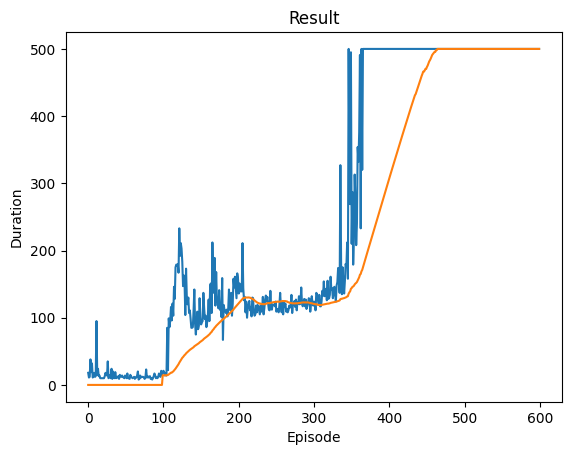

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [63]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count # Will be used for episode iteration

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# --- Environment Setup ---
env = gym.make("CartPole-v1")

# set up matplotlib for plotting
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion() # Turn interactive mode on for plots

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Replay Buffer (Transition and ReplayMemory Class) ---
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# --- DQN Model ---
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        # Ensure x is a FloatTensor and on the correct device
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=device, dtype=torch.float32)
        elif x.dtype != torch.float32:
            x = x.to(device=device, dtype=torch.float32)
        else:
            x = x.to(device) # Ensure it's on the correct device

        # If x is 1D (e.g. [features]), unsqueeze it to make it a batch of 1 ([1, features])
        # This check is generally for single state predictions.
        # For batched input [BATCH_SIZE, features], ndim will be 2.
        if x.ndim == 1:
            x = x.unsqueeze(0)

        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# --- Hyperparameters & Initializations ---
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005 # Soft update parameter for target network
LR = 1e-4   # Learning rate

n_actions = env.action_space.n
initial_state, info = env.reset()
n_observations = len(initial_state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() # Target network is in eval mode

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0
episode_durations = [] # To store duration of each episode for plotting

# --- Action Selection ---
def select_action(state_tensor): # state_tensor is expected to be [1, n_observations], float, on device
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # policy_net expects a batched input
            return policy_net(state_tensor).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

# --- Plotting Utility ---
def plot_durations(show_result=False):
    plt.figure(1) # Ensure we're drawing on figure 1
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf() # Clear the figure to redraw
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means)) # Pad with zeros for alignment
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


# --- Optimization Step (Corrected Version) ---
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch. This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # batch.state contains tensors of shape [1, n_observations]
    # batch.action contains tensors of shape [1, 1]
    # batch.reward contains tensors of shape [1]
    # batch.next_state contains tensors of shape [1, n_observations] or None
    # batch.done contains tensors of shape [1] (boolean)

    # Concatenate along dimension 0 to form batches
    # Each element in batch.state is already a [1, n_obs] tensor, float and on device.
    state_batch = torch.cat(batch.state, dim=0)         # Shape: [BATCH_SIZE, n_observations]
    action_batch = torch.cat(batch.action, dim=0)       # Shape: [BATCH_SIZE, 1]
    reward_batch = torch.cat(batch.reward, dim=0)       # Shape: [BATCH_SIZE]

    # Create a mask for non-final next states
    non_final_mask = torch.tensor(tuple(s is not None for s in batch.next_state),
                                  device=device, dtype=torch.bool) # Shape: [BATCH_SIZE]
    
    # Create a batch of non-final next states
    # Each element 's' in batch.next_state (if not None) is already [1, n_obs] tensor, float and on device
    non_final_next_states_list = [s for s in batch.next_state if s is not None]
    
    # --- Debug Prints START ---
    # Calculate policy_net output separately to print its shape
    policy_net_output = policy_net(state_batch) 
    print(f"--- Debug ---")
    print(f"Shape of state_batch: {state_batch.shape}, Ndim: {state_batch.ndim}")
    print(f"Shape of policy_net_output (from policy_net(state_batch)): {policy_net_output.shape}, Ndim: {policy_net_output.ndim}")
    print(f"Shape of action_batch: {action_batch.shape}, Ndim: {action_batch.ndim}")
    if policy_net_output.ndim != action_batch.ndim:
        print(f"ERROR PREDICTED: Dimensions do not match for gather!")
    print(f"--- End Debug ---")
    # --- Debug Prints END ---

    state_action_values = policy_net_output.gather(1, action_batch) # Expected Shape: [BATCH_SIZE, 1]

    next_state_values = torch.zeros(BATCH_SIZE, device=device) # Expected Shape: [BATCH_SIZE]
    if len(non_final_next_states_list) > 0:
        non_final_next_states_batch = torch.cat(non_final_next_states_list, dim=0) # Expected Shape: [num_non_final, n_observations]
        with torch.no_grad():
            next_state_values[non_final_mask] = target_net(non_final_next_states_batch).max(1).values
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch # Expected Shape: [BATCH_SIZE]

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# --- Main Training Loop ---
if torch.cuda.is_available():
    num_episodes = 600 
else:
    num_episodes = 250 

print(f"Starting training for {num_episodes} episodes...")

for i_episode in range(num_episodes):
    state, info = env.reset()
    # Ensure initial state_tensor is [1, n_observations], float, and on device
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    current_episode_duration = 0
    for t in count(): 
        action_tensor = select_action(state_tensor) # Expects [1, n_obs], float, on device
        observation, reward, terminated, truncated, _ = env.step(action_tensor.item())
        reward_tensor = torch.tensor([reward], device=device, dtype=torch.float32) # Ensure float for consistency
        done = terminated or truncated
        current_episode_duration +=1

        if terminated: # True terminal state
            next_state_tensor = None
        else: # Non-terminal or truncated
            next_state_tensor = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state_tensor, action_tensor, next_state_tensor, reward_tensor, torch.tensor([done], device=device, dtype=torch.bool))

        state_tensor = next_state_tensor

        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(current_episode_duration)
            plot_durations()
            if (i_episode + 1) % 20 == 0: 
                 print(f"Episode {i_episode+1}/{num_episodes} | Duration: {current_episode_duration} | Epsilon: {EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY):.4f}")
            break
    
    if len(episode_durations) >= 100:
        mean_duration = np.mean(episode_durations[-100:])
        if mean_duration >= 475.0 : 
             print(f"CartPole solved in {i_episode+1} episodes! Average duration over last 100 episodes: {mean_duration:.2f}")
             # break # Uncomment to stop training once solved

print('Complete training.')
plot_durations(show_result=True)
plt.ioff() 
plt.show() 

env.close()

In [2]:
print("Training complete. Visualizing trained agent...")
# Ensure the original training env is closed if you are reusing the 'env' variable
# env.close() # Assuming it was already called after the training loop

eval_env = gym.make("CartPole-v1", render_mode="human")
num_eval_episodes = 5 # Or however many you want to watch

# Set the policy_net to evaluation mode
policy_net.eval()

for i_episode in range(num_eval_episodes):
    state, info = eval_env.reset()
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    terminated = False
    truncated = False
    total_reward = 0
    print(f"--- Evaluation Episode {i_episode + 1} ---")
    for t in count():
        with torch.no_grad(): # No need to calculate gradients
            # For evaluation, always use the greedy action from the policy network
            action_tensor = policy_net(state_tensor).max(1).indices.view(1, 1)

        observation, reward, terminated, truncated, _ = eval_env.step(action_tensor.item())
        total_reward += reward

        done = terminated or truncated

        if done:
            print(f"Episode finished after {t+1} timesteps. Total reward: {total_reward}")
            break

        state_tensor = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # A small delay to make rendering human-watchable if it's too fast
        # import time
        # time.sleep(0.01) # Sleep for 10 milliseconds

eval_env.close()
print("Visualization finished.")

Training complete. Visualizing trained agent...


NameError: name 'gym' is not defined


--- Starting Agent Evaluation: cartpole_final_eval_run_1 ---
Created directory: videos/dqn_performance_showcase/cartpole_final_eval_run_1
Videos will be saved to: videos/dqn_performance_showcase/cartpole_final_eval_run_1 (1st ep & every 10).


c:\Users\sgud7\.conda\envs\REin-Medo\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at e:\College\projects\AI-ML\Reinforcement\cart-pole\videos\dqn_performance_showcase\cartpole_final_eval_run_1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


DependencyNotInstalled: MoviePy is not installed, run `pip install "gymnasium[other]"`